# Notes

In [1]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path
from PIL import Image

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import joblib, json

from  sklearn.model_selection  import StratifiedKFold

In [2]:
PART_ID = 0 # The start index in the below list, by changing it you will compute mels on another subset
PART_INDEXES = [0,15718, 31436, 47154, 62874] # The train_set is splitted into 4 subsets

In [3]:
SR = 32_000
DURATION = 7 
SEED = 666

DATA_ROOT = Path("../input/birdclef-2021")
TRAIN_AUDIO_ROOT = Path("../input/birdclef-2021/train_short_audio")
TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("audio_images") # Where to save the mels images
TRAIN_AUDIO_IMAGES_SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [4]:
def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [5]:
def make_df(n_splits=5, seed=SEED, nrows=None):
    
    df = pd.read_csv(DATA_ROOT/"train_metadata.csv", nrows=nrows)

    LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}
    
    df = df.iloc[PART_INDEXES[PART_ID]: PART_INDEXES[PART_ID+1]]

    df["label_id"] = df["primary_label"].map(LABEL_IDS)

    df["filepath"] = [str(TRAIN_AUDIO_ROOT/primary_label/filename) for primary_label,filename in zip(df.primary_label, df.filename) ]

    pool = joblib.Parallel(4)
    mapper = joblib.delayed(get_audio_info)
    tasks = [mapper(filepath) for filepath in df.filepath]

    df = pd.concat([df, pd.DataFrame(pool(tqdm(tasks)))], axis=1, sort=False)
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = skf.split(np.arange(len(df)), y=df.label_id.values)
    df["fold"] = -1

    for fold, (train_set, val_set) in enumerate(splits):
        
        df.loc[df.index[val_set], "fold"] = fold

    return LABEL_IDS, df

In [6]:
LABEL_IDS, df = make_df(nrows=None)

df.to_csv("rich_train_metadata.csv", index=True)
with open("LABEL_IDS.json", "w") as f:
    json.dump(LABEL_IDS, f)

print(df.shape)
df.head()

  0%|          | 0/15718 [00:00<?, ?it/s]

(15718, 20)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,label_id,filepath,frames,sr,duration,fold
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2


In [7]:
df["fold"].value_counts()

0    3144
1    3144
2    3144
3    3143
4    3143
Name: fold, dtype: int64

In [8]:
df["primary_label"].value_counts()

barswa     500
amerob     481
bewwre     466
carwre     464
bncfly     406
          ... 
amewig      38
bucmot2     38
cacgoo1     36
blctan1     35
clcrob      14
Name: primary_label, Length: 100, dtype: int64

<AxesSubplot:>

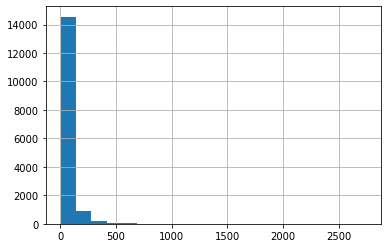

In [9]:
df["duration"].hist(bins=20)

<AxesSubplot:>

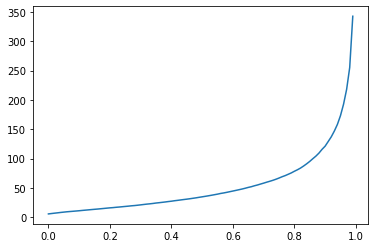

In [10]:
df["duration"].quantile(np.arange(0, 1, 0.01)).plot()

In [11]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [12]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

In [13]:
class AudioToImage:
    def __init__(self, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=None, res_type="kaiser_fast", resample=True):

        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
#         image = normalize(image, mean=None, std=None)
        return image

    def __call__(self, row, save=True):
#       max_audio_duration = 10*self.duration
#       init_audio_length = max_audio_duration*row.sr
        
#       start = 0 if row.duration <  max_audio_duration else np.random.randint(row.frames - init_audio_length)
    
      audio, orig_sr = sf.read(row.filepath, dtype="float32")

      if self.resample and orig_sr != self.sr:
        audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
        
      audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
      audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
      images = [self.audio_to_image(audio) for audio in audios]
      images = np.stack(images)
        
      if save:
        path = TRAIN_AUDIO_IMAGES_SAVE_ROOT/f"{row.primary_label}/{row.filename}.npy"
        path.parent.mkdir(exist_ok=True, parents=True)
        np.save(str(path), images)
      else:
        return  row.filename, images

In [14]:
def get_audios_as_images(df):
    pool = joblib.Parallel(2)
    
    converter = AudioToImage(step=int(DURATION*0.666*SR))
    mapper = joblib.delayed(converter)
    tasks = [mapper(row) for row in df.itertuples(False)]
    
    pool(tqdm(tasks))

In [15]:
get_audios_as_images(df)

  0%|          | 0/15718 [00:00<?, ?it/s]

In [16]:
row = df.loc[df.duration.idxmax()]
mels = np.load(str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/row.primary_label/row.filename).as_posix() + ".npy"))
print(mels.shape)

(587, 128, 281)


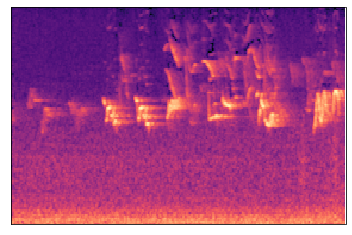

In [17]:
lbd.specshow(mels[0])

In [18]:
df["img_path"] = [str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/row.primary_label/row.filename).as_posix() + ".npy") for primary_label,filename in zip(df.primary_label, df.filename) ]

In [19]:
df['img_path'][0]

'audio_images/blbthr1/XC147860.ogg.npy'